## **Solución del portafolio de mínima varianza con el método de Marcowitz** 




**Infraestructura de ejecución**:En este notebook se utilizó colab para la ejecución del algoritmo, pero se tiene una instancia en AWS con un Docker file configurado para la ejecución del algoritmo con GPU's.

**Definición del problema:**<br>
Se busca implementar un algoritmo (en paralelo) con la herramienta de *cupy* del lenguaje de pyhton para encontrar la proporción de dinero que cierto inversionista debe invertir en un conjunto de acciones. A estas proporciones las denotaremos $wi$ o pesos, que finalmente será una tabla que indique el nombre de la acción evaluada y el porcentaje a destinar o invertir en dicha empresa.<br>

Este algoritmo se basa en el modelo de **Markovitz**, en el cual se busca la frontera de posibilidades de alocación para invertir y se enfoca en la parte superior de esta frontera porque justamente en esa parte los rendimientos son positivos.
Esta frontera es representada por un función concava horizontal y el punto mínimo de esta función representa la varianza más baja posible que se puede lograr para un rendimiento esperado de una cartera determinada. Dados los datos de entrada para los retornos, variaciones y covarianzas esperados, podemos calcular la cartera de variación mínima para cualquier rendimiento esperado.

En términos matemáticos el algoritmo desarrolado debe minimizar la siguiente función objetivo: <br>

$$\min_{w}  \frac{1}{2} w^t \Sigma w$$ <br>

* Donde $w$ es el vector de pesos de las acciones que puede ser inicializado de forma aleatoria.<br>
* $\Sigma$ es la matriz de varianzas y covarianzas.<br>

Este es un problema con restricciones y son las siguientes:<br>
$$ w^t \mu= r$$<br>
* En esta primera restricción se define el retorno esperado del portafolio de acciones<br>

$$ w^t 1= 1$$<br>
* Con esta restricción se cumple que el vector de pesos $wi$ es igual a 1, es decir que se agota el presupuesto destinado a la inversión. 


En terminos financieros este modelo se enfoca en los inversionistas aversos al riesgo, es por eso que buscamos el portafolio de mínima varianza (o menor riesgo), en donde el riesgo esta determinado por la desviación estandar de los activos o acciones. <br>

El algoritmo tiene 3 etapas para su solución:<br>

* Etapa I- consiste en la extracción de los datos históricos(precios) de ciertas empresas a evaluar.
* Etapa II - se enfoca en encontrar funciones que nos ayuden a determinar el retornos esperado de las acciones y la matriz de varianzas-covarianzas de los rendimientos.
* Etapa III- se obtienen funciones auxiliares para finalmente optimizar la función objetivo para determinar el vector de pesos $wi$ de las acciones

In [1]:
#Para el uso de cupy con GPU en google colab
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3590      0 --:--:-- --:--:-- --:--:--  3599
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


**Etapa I - Extracción, limpieza y transformación**<br>


In [0]:
#Importamos el modulo creado para la solución del algoritmo
import extraer_datos_yahoo
import funciones_auxiliares
import modelo_markowitz
import punto_factible
import pandas as pd
import cupy as cp
import pprint

Para la extracción de la base de datos de precios históricos, se utilizó una librería ya implementada en Pyhton *fix_yahoo_finance* con la cual es posible descargar los precios históricos de las acciones que se quieran evaluar, sólo es necesario proporcionar el código bursátil de las acciones .<br>

En este caso propuesimos la evaluación de 50 empresas que cotizan en bolsa de cada una de las industrias más importantes del mercado, por ejemplo: la industría de tecnología, industria del retail, etc. <br>

Se escogieron la empresas que tienen mayor participación de mercado (*market share*) en esa industria a la que pertenece. El precio para determinar los rendimientos es el precio de cierre (*closed price*) de los últimos 5 años para hacer el análisis, pero este puede ser modificable a más años atrás.

In [3]:
# Códigos bursátiles de las acciones a evaluar
stocks = ['COP','AMT','LIN','LMT','AMZN','WMT','JNJ','VTI','MSFT','GOOG','XOM','CCI','BHP.AX','UNP',
'BABA','NSRGY','RHHBY','VOO','AAPL','FB','CVX','PLD','RIO.L','HON','HD','PG','UNH','BRK-A','V','0700.HK',
'RDSA.AS','0688.HK','AI.PA','RTX','MC.PA','KO','PFE','JPM','005930.KS','VZ','RELIANCE.NS','DLR','2010.SR',
'UPS','7203.T','PEP','MRK','1398.HK','MA','T']

# Utilizamos la función que extrae los datos
datos = extraer_datos_yahoo.extraer_datos_yahoo(stocks)

[*********************100%***********************]  50 of 50 downloaded


Se puede consultar la infromación de la funcion *extraer_datos_yahoo* en la documentación de la función, pero recibe como argumento el código bursátil las acciones a descargar y tiene un rango de fechas (que puede cambiarse) para obtener el precio de las acciones, de igual manera se indica en esa función que el precio deseado para el análsis es el *precio de cierre* de la bolsa.<br>

Ahora examinamos los datos recién descargados:

In [4]:
datos

,005930.KS,0688.HK,0700.HK,1398.HK,2010.SR,7203.T,AAPL,AI.PA,AMT,AMZN,BABA,BHP.AX,BRK-A,CCI,COP,CVX,DLR,FB,GOOG,HD,HON,JNJ,JPM,KO,LIN,LMT,MA,MC.PA,MRK,MSFT,NSRGY,PEP,PFE,PG,PLD,RDSA.AS,RELIANCE.NS,RHHBY,RIO.L,RTX,T,UNH,UNP,UPS,V,VOO,VTI,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,26600.0,24.704800,112.800003,5.77,79.500000,7507.0,109.330002,89.786400,99.669998,308.519989,103.599998,27.603399,223600.0,79.510002,68.919998,112.580002,66.410004,78.449997,523.373108,103.430000,95.556229,104.519997,62.490002,42.139999,129.949997,193.309998,85.680000,130.850006,57.189999,46.759998,72.650002,94.440002,31.330000,90.440002,43.430000,27.750000,442.774994,33.910000,2970.0,72.397736,33.869999,100.779999,118.610001,110.379997,66.254997,188.399994,105.919998,46.959999,85.900002,92.830002
2015-01-05,26660.0,24.951799,113.500000,5.80,79.500000,7507.0,106.250000,87.005997,98.230003,302.190002,101.000000,27.547300,220980.0,79.000000,65.639999,108.080002,67.690002,77.190002,512.463013,101.260002,93.735291,103.790001,60.549999,42.139999,126.519997,189.289993,83.269997,127.050003,58.040001,46.330002,70.959999,93.730003,31.160000,90.010002,43.400002,26.615000,437.924988,34.029999,2883.5,71.189430,33.549999,99.120003,114.599998,108.169998,64.792503,185.089996,104.099998,46.570000,85.650002,90.290001
2015-01-06,25900.0,24.605900,120.000000,5.71,77.000000,7300.0,106.260002,86.279999,97.970001,295.290009,103.320000,26.267099,220450.0,78.849998,62.930000,108.029999,67.480003,76.150002,500.585632,100.949997,93.516014,103.279999,58.980000,42.459999,124.900002,188.399994,83.089996,125.599998,60.320000,45.650002,70.610001,93.019997,31.420000,89.599998,43.549999,26.514999,418.049988,33.900002,2944.5,70.182503,33.599998,98.919998,112.230003,107.459999,64.375000,183.270004,103.080002,47.040001,86.309998,89.809998
2015-01-07,26140.0,24.507099,124.400002,5.75,78.250000,7407.0,107.750000,86.669601,99.000000,298.420013,102.129997,26.267099,223480.0,80.500000,63.349998,107.940002,68.019997,76.150002,499.727997,104.410004,94.192909,105.559998,59.070000,42.990002,126.300003,190.830002,84.220001,125.699997,61.610001,46.230000,70.750000,95.739998,31.850000,90.070000,44.209999,26.870001,427.149994,33.990002,2962.5,70.943993,33.169998,99.930000,112.849998,108.459999,65.237503,185.559998,104.309998,46.189999,88.599998,90.720001
2015-01-08,26280.0,23.864799,127.300003,5.72,79.250000,7554.0,111.889999,90.317703,99.919998,300.459991,105.029999,26.519400,226680.0,81.769997,64.930000,110.410004,68.910004,78.180000,501.303680,106.720001,95.908974,106.389999,60.389999,43.509998,128.380005,195.130005,85.529999,129.649994,62.849998,47.590000,71.459999,97.480003,32.500000,91.099998,44.220001,27.495001,421.024994,34.279999,3027.5,72.152298,33.500000,104.699997,117.080002,110.410004,66.112503,188.820007,106.150002,47.180000,90.470001,92.230003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,52100.0,26.200001,411.600006,5.06,70.300003,6570.0,275.029999,117.599998,248.600006,2399.449951,205.240005,29.750000,278750.0,160.550003,36.180000,86.800003,148.529999,185.130005,1276.310059,202.320007,134.679993,155.509995,89.389999,45.070000,181.300003,376.730011,255.860001,348.649994,80.879997,171.419998,106.000000,130.259995,36.689999,119.400002,86.750000,16.521999,1370.900024,44.180000,3783.0,63.290001,29.500000,285.329987,152.289993,99.449997,166.380005,256.420013,139.550003,57.590000,128.529999,43.450001
2020-04-24,52100.0,26.100000,406.399994,5.06,70.300003,6543.0,282.970001,115.300003,244.610001,2410.219971,204.360001,30.540001,279460.0,161.610001,36.090000,87.010002,150.029999,190.070007,1279.310059,212.179993,135.520004,154.860001,90.709999,45.430000,181.470001,381.769989,258.760010,340.850006,81.430000,174.550003,109.220001,134.360001,37.380001,118.779999,89.040001,15.978000,1417.000000,45.

Se obtiene un dataframe de 1340 columnas que son los días cotizados en cada hábiles desde el 1ro de Enero del 2015, de igual manera se realizó la imputación sobre las empresas que no cotizaron algún día de los 1340 por alguna razón para de esta manera tener la serie de tiempo de los precios para todas la empresas en la misma frecuencia de tiempo y asi obtener los rendimientos de esos precios.<br>

Para la imputación a los *missing data*, se decidió que si algún día hábil no tenía cotización se pusiera como dato el precio del día anterior, ya que el promedio de los precios para esa empresa en 5 años tiene mucha variabilidad.

**Etapa II - Calculamos el retorno esperado del portafolio y la matriz de varianzas-covarianzas de los rendimientos**<br>

In [5]:
#Aplicamos la función para obtener los rendimientos de las acciones
rendimientos = funciones_auxiliares.calcular_rendimiento_vector(datos)
rendimiento_df=pd.DataFrame(rendimientos)
rendimiento_df.columns=['005930.KS','0688.HK','0700.HK','1398.HK','2010.SR','7203.T','AAPL',
'AI.PA','AMT','AMZN','BABA','BHP.AX','BRK-A','CCI','COP','CVX','DLR','FB','GOOG','HD','HON',
'JNJ','JPM','KO','LIN','LMT','MA','MC.PA','MRK','MSFT','NSRGY','PEP','PFE','PG','PLD','RDSA.AS',
'RELIANCE.NS','RHHBY','RIO.L','RTX','T','UNH','UNP','UPS','V','VOO','VTI','VZ','WMT','XOM']
rendimiento_df

,005930.KS,0688.HK,0700.HK,1398.HK,2010.SR,7203.T,AAPL,AI.PA,AMT,AMZN,BABA,BHP.AX,BRK-A,CCI,COP,CVX,DLR,FB,GOOG,HD,HON,JNJ,JPM,KO,LIN,LMT,MA,MC.PA,MRK,MSFT,NSRGY,PEP,PFE,PG,PLD,RDSA.AS,RELIANCE.NS,RHHBY,RIO.L,RTX,T,UNH,UNP,UPS,V,VOO,VTI,VZ,WMT,XOM
0,0.002253098962909259,0.00994836706883783,0.006186471261754438,0.0051858370323654155,0.0,0.0,-0.02857604193510772,-0.03145646886389706,-0.014553010685800262,-0.020730670170655243,-0.02541679367910377,-0.0020343901479210396,-0.011786541595915133,-0.006434972600438926,-0.04876113165329865,-0.04079238564427063,0.019090780282464418,-0.016191500066268846,-0.021066070681864047,-0.021203569096813677,-0.019240103019862665,-0.007008775337733556,-0.03153712246228616,0.0,-0.026749363275915036,-0.02101491394969156,-0.028531121919146828,-0.02947094145126143,0.014753404803833602,-0.00923835123513766,-0.023537093636663904,-0.00754639262955717,-0.005440883961552829,-0.004765872035130767,-0.0006909593574231074,-0.04176087356772283,-0.011014091356037143,0.0035325029894307165,-0.029557118741277973,-0.01683067584329173,-0.009492803693595791,-0.016608645742617976,-0.034393021643544644,-0.02022488567973501,-0.022320986216330895,-0.01772515863761147,-0.017332116897895447,-0.008339597230835973,-0.002914604152121422,-0.02774316156178879
1,-0.028921346045070545,-0.013959672226260903,0.05568890586058863,-0.015638893884454778,-0.03195159980660236,-0.027961570436519863,9.413204002870386e-05,-0.008379237382647743,-0.002650378663588673,-0.023098010453310284,0.022710451386380313,-0.04758735971535761,-0.0024012878810822777,-0.0019005644225908096,-0.04216225344843483,-0.0004627550845489362,-0.0031071859315941327,-0.013564835266731039,-0.02344986162445733,-0.0030661712517346326,-0.002342062184640283,-0.004925899756066904,-0.02627105009669437,0.0075650480779115336,-0.012886941581439566,-0.004712863342704226,-0.002163994684028167,-0.01147849526839249,0.03853127845421664,-0.014786091744542793,-0.004944532218322163,-0.00760384922040038,0.008309411824927695,-0.004565499829291085,0.0034501931470914686,-0.003764393750129313,-0.04644662154439208,-0.003827385743524768,0.0209341893291581,-0.014245317390388154,0.001489173833916184,-0.0020198451523734604,-0.020897423069647363,-0.006585369157895983,-0.006464543236765771,-0.009881674502010267,-0.009846551222057064,0.01004176785458895,0.007676194938304775,-0.005330417981188443
2,0.009223739490583761,-0.004023420898480203,0.03601045360020337,0.006980831141340141,0.016103407566578673,0.014551150876806699,0.013924789139302327,0.004505389535783031,0.010458530570832786,0.01054397898729664,-0.011584486011959307,0.0,0.013651012787001442,0.020709896380087075,0.006651877657666021,-0.0008334213528966246,0.007970433338989816,0.0,-0.001714732630405109,0.033700179571360823,0.007212208384028969,0.021835755832582182,0.0015247779320136992,0.012405144307104533,0.011146619965072211,0.01281565954422652,0.013508125071127575,0.0007958536193215966,0.021160487557909956,0.012625287147547296,0.001980744832791766,0.028821671529630936,0.013592749190697317,0.005231848136195444,0.0150413048824356,0.013299886969034138,0.021534211659673817,0.0026513491654055745,0.00609448305876121,0.010791699813703688,-0.012880214781835682,0.010158518438841238,0.005509121781919183,0.009262756198038541,0.013309143971451439,0.012417771949851305,0.011861810327692304,-0.018235022056068702,0.026186391978391572,0.010081545588746644
3,0.005341485420333782,-0.026558302635292675,0.023044332747489845,-0.005231049417552556,0.012698583337127343,0.019651725259113018,0.03770250789842336,0.04123028825339465,0.009249995666719281,0.006812669905168322,0.027999531897914466,0.009559373176203903,0.014217406710470382,0.01565320706109565,0.024634891323887187,0.022625209960338538,0.012999627941469102,0.02630875475968567,0.0031481207588969174,0.02188309692510341,0.018054651413263505,0.007832085440342583,0.02210033044163278,0.012023173735506773,0.01633460172109365,0.022283038891495188,0.015434745293440433,0.030940373976377396,0.019926691956847487,0.02899

El rendimiento diario de las acciones se obtiene de la siguiente forma:<br>
$$\ r= log( \frac{Pt}{Pt_1})$$ <br>

Para cada uno de los códigos bursátiles, en este caso se pierde un registro por el mecanismo de la fórmula, por lo que tenemos rendimientos de 1339 dias.<br>

Posteriormente calculamos el promedio de los rendimientos diarios y convertimos esos rendimientos a  anuales, para tener un mejor análisis en la obtención del portafolio. Para la conversión del promedio de los rendimientos a tasa anual se hizo lo siguiente:<br>

$$\ r_{anual}= r_{diario}*264$$ <br>

La razón de multiplicar por 264 los rendimientos diarios es porque son los días que usualmeten las bolsas del mundo cotizan acciones al año.



**Vector del promedio de los rendimientos diarios**

In [6]:
#Obtenemos el vector de rendimientos promedio de las acciones
mu = funciones_auxiliares.calcular_rendimiento(datos)
mu = cp.array(mu)

#Se obtiene un array de tamaño 50 que son las acciones evaluadas
mu.shape

(50,)

**Matriz de varianza y covarianza de los rendimientos**

In [7]:
#Obtenemos la matriz de var-cov
Sigma = funciones_auxiliares.calcular_varianza(datos)

Sigma.shape

(50, 50)

**Rendimiento máximo de los rendimientos promedios**<br>

PAra resovler el problema suponemos que el retorno máximo del promedio de los rendimientos obtenidos es lo que espera recibir el inversionista y a partir de este rendimiento se buscaran los pesos $wi$ que se debe destinar a las empresas.



In [8]:
#Rendimiento máximo del vector de rendimientos
r=max(mu)
r

array(0.40221088)

**Etapa III - Solución de la función objetivo a minimizar- Solver de Marcowitz**<br>

Para la solución del problema de minimización del portafolio de mínimia varianza se utiliza el método numérico de multiplicadores de lagrange con restricciones. La solución a este problema de optimización se aborda con restricciones através de las ecuaciones inducidas donde se involucra la matriz de covarianzas de los rendimientos de las acciones, el rendimiento medio y el retorno esperado del portafolio, como explica a continuación.<br>

Definición del **lagrangiano**:

$$L(w,\lambda_{1}, \lambda_{2}) = \frac{1}{2}w^T\Sigma w +  \lambda_{1}(r-w^T\mu) + \lambda_{2}(1-w^T1_{n})$$

Donde el primer termino es la función a optimizar y los siguientes dos terminos son las restricciones.

Se derivan las Condiciones de primer orden

$\frac{\delta L}{\delta w} = 0_{n} = \Sigma w - \lambda_{1}\mu - \lambda_{2}1_{n}$

$\frac{\delta L}{\delta \lambda_{1}} = 0 = r -w^T\mu$

$\frac{\delta L}{\delta \lambda{2}} = 0 = 1 -w^T1_{n}$

Resolver para w en términos de $\lambda_{1}$ y $\lambda_{2}$

$w_{0} = \lambda_{1}\Sigma^{-1}\mu \oplus \lambda_{2}\Sigma^{-1}1_{n}$

Resolver para $\lambda_{1}$ y $\lambda_{2}$ sustituyendo w

$r = w^T_{0}\mu = \lambda_{1}(\mu^T\Sigma^{-1}\mu) + \lambda_{2}(\mu^T\Sigma^{-1}1_{n}))$

$1 = w^T 1_{n} = \lambda_{1}(\mu^T\Sigma^{-1}1_{n}) + \lambda_{2}(1^T_{n}\Sigma^{-1}1_{n})$ 


$$
\begin{bmatrix}
    r \\
    1 
  \end{bmatrix}
=
\begin{bmatrix}
     A & C  \\
     C & B
  \end{bmatrix}
=
\begin{bmatrix}
    \lambda_{1}\\
   \lambda_{2} 
  \end{bmatrix}
$$

$A =(\mu^T\Sigma^{-1}\mu), B = (1^T_{n}\Sigma^{-1}1_{n}), C =(1_{n}^T\Sigma_{-1}\mu) $


**Funciones auxiliares** <br>

$$w_{0}=\frac{1}{\Delta }(\hat{r}\cdot B-C)$$ <br>
$$w_{1}=\frac{1}{\Delta }(A-C\cdot \hat{r})$$<br>

Donde: <br>
$$\Delta =A\cdot B-C^2$$ 
$$A=\mu^t\cdot \Sigma^{-1}\cdot \mu$$
$$B=1^t\cdot \Sigma^{-1}\cdot 1$$ 
$$C=1^t\cdot \Sigma^{-1}\cdot \mu$$

In [9]:
#Obtenemos los vectores auxiliares u y v
u, v =modelo_markowitz.formar_vectores(mu, Sigma)

#Se obtienen los valores A,B,C con ayuda de los vectores auxiliares
A, B, C = modelo_markowitz.formar_abc(mu, Sigma)

#Definimos Delta = AB-C^2
Delta=modelo_markowitz.delta(A,B,C)
Delta

array(63932058.96057558)

In [0]:
#Para la determinación de w_0 y w_1 aplicamos la funcion "formar_omegas"
w_0, w_1= modelo_markowitz.formar_omegas(r, mu, Sigma)

Justamente en la determinación de las omegas w_0 y w_1 se utilizan todas las funciones auxiliares generadas anteriormente.

In [11]:
#Matriz w_0
w_0

array(0.00014092)

In [12]:
#Matriz w_1
w_1

array(3.791824e-05)

In [13]:
#Solución de Marcowitz
w=modelo_markowitz.markowitz(r, mu, Sigma)

#Desplegamos el vector de pesos
#w
w_df=modelo_markowitz.markowitz_df(r, mu, Sigma,stocks)
w_df

,pesos,stocks
9,0.286001,GOOG
47,0.263296,1398.HK
12,0.203076,BHP.AX
19,0.198110,FB
30,0.192198,RDSA.AS
46,0.189812,MRK
26,0.169294,UNH
36,0.164033,PFE
0,0.158450,COP
2,0.158052,LIN


De esta manera obtenemos las pesos **$wi$** que un inversionista debe asignar en un portafolio que contenga este conjunto de acciones. <br>

Los pesos o ponderaciones que son mas grandes indican que en ese punto se debe invertir mayor cantidad de dinero porque se tendrá un mayor rendimiento. Del mismo modo, se observa que hay pesos negativos y esto sucede porque estamos en el supuesto de que se permiten **Ventas en Corto** (*Short Sales*). Se dice que un inversionista tiene una posición corta cuando tiene algún contrato de préstamo de títulos financieros, en este caso acciones y este contrato establece que dichos títulos se devolveran en una fecha futura, por lo que el inversionista puede adquirir estas acciones a un precio menor para devolverlas a su tenedor al finalizar el contrado, de esta manera el inversionista se estaría beneficiando por la diferencia en el costo de las acciones.

**Comprobación de las restricciones del problema**

1) Verificamos que $$ w^t 1= 1$$<br>

In [14]:
#Sumamos el vector de pesos obtenido
sum(w)

array(1.)

1) Verificamos que $$ w^t \mu= r$$<br>

In [15]:
pprint.pprint("Valor r ")
pprint.pprint(r)
pprint.pprint("Valor w*mu ")
pprint.pprint(w@mu)

'Valor r '
array(0.40221088)
'Valor w*mu '
array(0.40221088)


**Calculamos la varianza o riesgo del portafolio obtenido (óptimo)**

In [16]:
pprint.pprint("El riesgo del portafolio obtenido es ")
pprint.pprint(w.transpose()@Sigma@w)

'El riesgo del portafolio obtenido es '
array(9.45979246e-05)


La siguiente parte del proyecto consistira en realizar el método de newton al problema anteriormente planteada para así dar la importancia correspondiente a las restricciones de este.







## Método de Newton con reestricciones de igualdad

Consideraciones:

1) El punto inicial debe ser factible, es decir: $w\in domf$, $w^T\mu = r$ y $w^T1_{n} = 1$ 

2) El paso de Newton $\Delta w$, debe modificarse de modo que satisfaga las reestricciones.


### Aproximación de segundo orden
Supongase que w es un punto factible del problema y desarrollese vía el teorema de Taylor la aproximación de segundo orden con centro en el punto w para f

$$f: \hat{f}(w + v) = f(w) +\Delta f(w)^Tv +\frac{1}{2}v^T\Delta^2f(w)v$$

Entonces el problema que se resolvera es:

min $\hat{f}(w + v)$

Sujeto a:

- $(w + v)^T\mu=r$
- $(w + v)^T1_{n}=1$

con variable $v \in R^n$, el cual como f es convexa es un problema convexo de minimización cuadrática con reestricciones de igualdad.


## Análisis visual

In [0]:
import numpy as np
retornos = np.linspace(-2, 2, num=1000)
retornos
riesgo = []
for i in retornos:
  w_star = punto_factible.feasible_markowitz(i,mu.reshape(50,1))
  riesgo.append(1/2*(w_star.T@Sigma@w_star))
riesgo= np.sqrt(cp.asnumpy(np.stack( riesgo)))

In [0]:
riesgo_m = []
for i in retornos:
  w_star = modelo_markowitz.markowitz(i,mu,Sigma)
  riesgo_m.append(1/2*(w_star.T@Sigma@w_star))

riesgo_m= np.sqrt(cp.asnumpy(np.stack( riesgo_m)))


Seleccionando retornos del portafolio con valores entre (-1,1) y tomando algunos pesos $w$ que cumplen con las restricciones  $ w^t 1= 1$ y $ w^t \mu= r$  se calculó la desviación estándar, es decir, $\frac{1}{2} w^t \Sigma w$. La siguiente gráfica muestra algunos puntos factibles para retornos del portafolio con su respectiva desviación estándar.

Text(0.5, 1.0, 'Gráfica 2. Frontera de alocacion de portafolios')

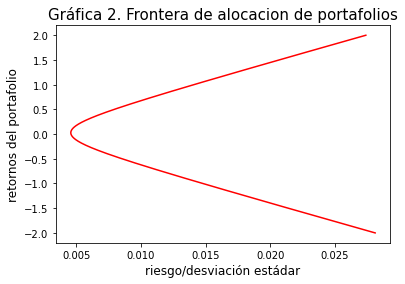

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(riesgo, retornos, 'o', markersize=4)
#plt.plot(riesgo_m, retornos, 'ro', markersize=5)
plt.plot(riesgo_m, retornos , 'r-', markersize=5)
#plt.plot(np.sqrt(np.diag(cp.asnumpy(Sigma))),cp.asnumpy(mu), 'bo', markersize=5)
plt.xlabel('riesgo/desviación estádar',size=12)
plt.ylabel('retornos del portafolio',size=12)
plt.title('Gráfica 2. Frontera de alocacion de portafolios',size=15)


La siguiente gráfica muestra los portafolios que serían seleccionados por el inversor, ya que tras realizar el problema de optimización de minimizar $\frac{1}{2} w^t \Sigma w$ se obtienen las desviaciones estándar (eje horizontal), es decir, el riesgo que el inversionista está dispuesto a tomar con respecto a diferentes retornos del portafolio entre valores (-1,1) (eje vertical).

Text(0.5, 1.0, 'Gráfica 1. Retornos del portafolio vs riesgo')

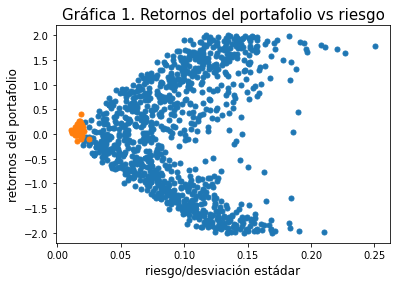

In [20]:
fig = plt.figure()
plt.plot(riesgo, retornos, 'o', markersize=5)
#plt.plot(riesgo_m, retornos , 'r-', markersize=5)
plt.plot(np.sqrt(np.diag(cp.asnumpy(Sigma))),cp.asnumpy(mu), 'o', markersize=5)
plt.xlabel('riesgo/desviación estádar',size=12)
plt.ylabel('retornos del portafolio',size=12)
plt.title('Gráfica 1. Retornos del portafolio vs riesgo',size=15)

La siguiente gráfica compara algunos puntos factibles, es decir posibles portafolios representados por los puntos azules, con los portafolios óptimos es decir los que el inversionista adverso al riesgo elegiria representados por los puntos rojos.

Text(0.5, 1.0, 'Retornos del portafolio vs su desviación estándar')

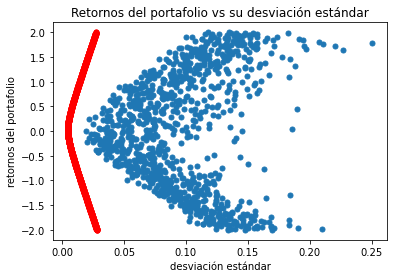

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(riesgo, retornos, 'o', markersize=5)
plt.plot(riesgo_m, retornos, 'ro', markersize=5)
#plt.plot(np.sqrt(np.diag(cp.asnumpy(Sigma))),cp.asnumpy(mu), 'bo', markersize=5)
plt.xlabel('desviación estándar')
plt.ylabel('retornos del portafolio')
plt.title('Retornos del portafolio vs su desviación estándar')

Dependiendo del retorno esperado del portafolio los pesos se ajustan, a continuación se presentan los casos en que los retornos esperados del portafolio son (0, 0.5, 1).

In [0]:
df1 =modelo_markowitz.markowitz_df(0,mu,Sigma,stocks)

In [0]:
df2 =modelo_markowitz.markowitz_df(0.4,mu,Sigma,stocks)

In [0]:
df3 =modelo_markowitz.markowitz_df(.6,mu,Sigma,stocks)

La siguiente gráfica muestra el caso en que el retorno del portafilio esperado es cero, es decir no hay ninguna ganancia, donde después de la optimización para encontrar los pesos con los que se obtiene mínima varianza, se presentó el siguiente resultado:

Siendo la empresa con código bursátil MRK a la que mayor peso se le tendría que dar en contraste con PP.


Text(0.5, 1.0, 'Gráfica 3. Pesos del portafolio con rendimiento = 0')

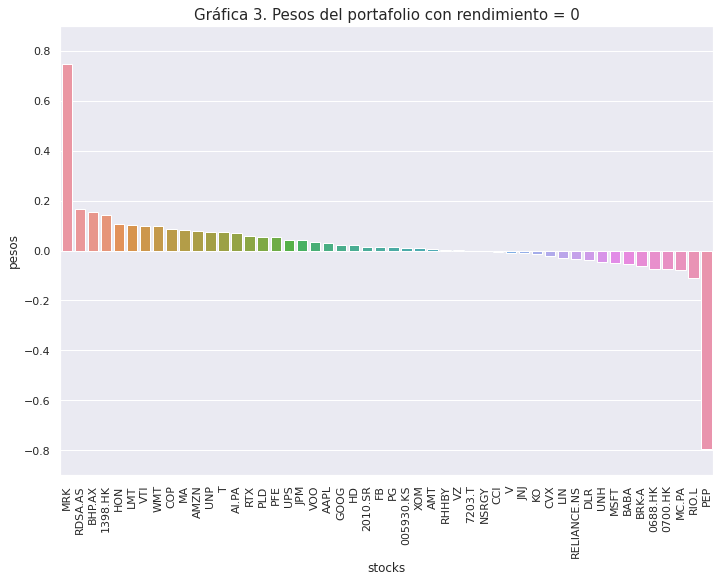

In [44]:
import seaborn as sns

#ax = sns.barplot(x=df1.index, y="peso", data=df1)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="stocks", y="pesos", data=df1,)
#ax.set_xticklabels(rotation=30)
#labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_ylim(-0.9, .9, .005)

ax.set_xticklabels(rotation=90,labels=df1.stocks)
ax.set_title('Gráfica 3. Pesos del portafolio con rendimiento = 0',size=15)

Las siguientes dos gráficas son los casos de retornos del portafolío esperados de 50% y 100% respectivamente, en estos casos es importante notar que al buscar retornos postivos las empresas con los siguientes códigos bursátiles destacan: GOOG, 1398.HK, FB , UNH, BHP.AX, LIN y RIO.L.

Sin embargo invertir en las empresas con códigos bursátiles VZ, LMT, T y PEP sería contraprudencente.

Text(0.5, 1.0, 'Gráfica 4. Pesos del portafolio con rendimiento = .4')

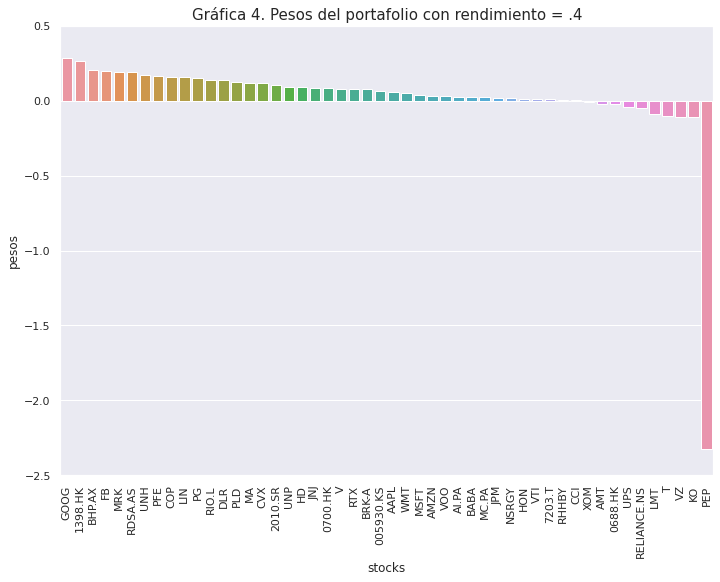

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="stocks", y="pesos",data=df2)
ax.set_xticklabels(rotation=90,labels=df2.stocks)
ax.set_ylim(-2.5, .5, .005)

ax.set_title('Gráfica 4. Pesos del portafolio con rendimiento = .4',size=15)

Text(0.5, 1.0, 'Gráfica 5. Pesos del portafolio con rendimiento = .6')

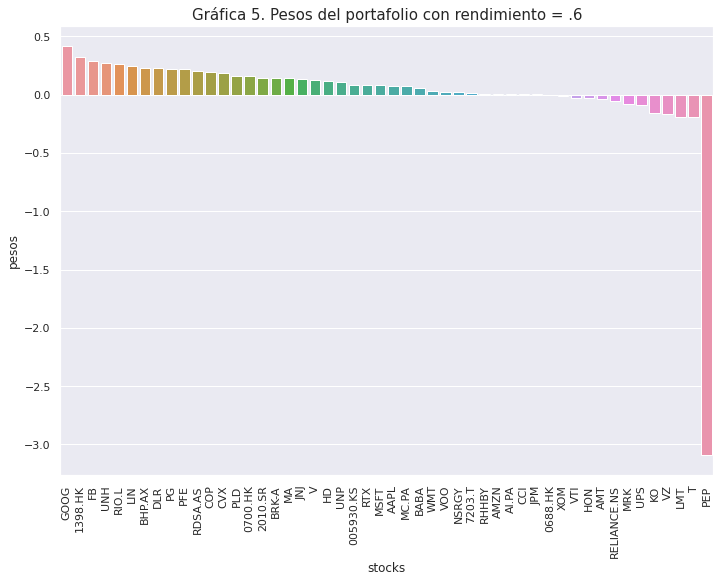

In [70]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="stocks", y="pesos",data=df3)
ax.set_xticklabels(rotation=90,labels=df3.stocks)
ax.set_title('Gráfica 5. Pesos del portafolio con rendimiento = .6',size=15)